In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
import time

import shutil

import PIL.Image

from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, apply_affine_transform
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import tensorflow as tf
tf.random.set_seed(21)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
BATCH_SIZE = 32
FOLDER = join(os.getcwd(), "data/annotated_regions")
FOLDER_0 = join(os.getcwd(), "data")
FOLDER_SMALL = join(os.getcwd(), "data/annotated_regions_small")
CSV_FILE = join(os.getcwd(),"data/train_annotations.csv")

GDRIVE_MOUNT = '/content/drive'
GDRIVE_FOLDER = "MyDrive/DataScientest/DS Project Datas"
FOLDER_MODELS = join(GDRIVE_MOUNT, GDRIVE_FOLDER, "Modeles")

def download_data(gdrive_folder):
  from google.colab import drive
  
  drive.mount(GDRIVE_MOUNT) 

  time.sleep(1)
  
  shutil.unpack_archive(join(GDRIVE_MOUNT,gdrive_folder,"annotated_regions.zip"), join("content",FOLDER_0))
  shutil.unpack_archive(join(GDRIVE_MOUNT, gdrive_folder,"annotated_regions_small.zip"), join("content",FOLDER_SMALL))
  shutil.copy(join(GDRIVE_MOUNT, gdrive_folder,"train_annotations.csv"), CSV_FILE)

## Le dossier DataScientest/DS Project Datas est à la racine de mon Google Drive.
download_data(GDRIVE_FOLDER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Préparation des données

In [ ]:
def df_test_train_split(images_small = True, classes = 4):

  """Retourne un df_train et un df_test qui contient les URI vers les images
     et les classes associées

    Parameters:
      images_small : Si True, on utilise les images de taille réduite 
                     dans le dossier FOLDER_SMALL, sinon on garde les 
                     images pleine taille du dossier FOLDER
      classes : Choix de 4 ou 2 classes (1 vs 2-3-4)
                ou "regression" si on souhaite réaliser une regression plutot qu'une classification                       

    Returns:
      df_train, df_test                   
  """

  df = pd.read_csv(CSV_FILE)

  if images_small :
    folder = FOLDER_SMALL
  else:
    folder = FOLDER

  df["filename"] = folder + "/" + df.annotation_id + ".jpeg"
  
  if classes == 4:
    df['class'] = df['annotation_class'].astype('string')
  elif classes == 2:
    df["class"] = df.annotation_class.replace([1,2,3],1).astype('string')
  elif classes == "regression":
    df['class'] = df['annotation_class'].astype('float')

  df.drop(columns=["annotation_id","annotation_class"], inplace=True)

  df_train=df.sample(frac=0.85, random_state=21).copy()
  df_test=df.drop(df_train.index).copy()

  return df_train, df_test

# df_train, df_test = df_test_train_split(images_small = False, classes = 4)
# df_train




###
# Création des générateurs d'images augmentées
# Reprend la fonction df_test_train_split précédente, et on fait passer : 
# - la fonction de préprocessing du CNN utilisé
# - les aumgentations souhaitées (soit un dict, soit une fonction)
###

def get_generators( images_small = True, classes = 4, preprocess_input = None, augmentation_input = None, rescale = 1):

  """Crée des générateurs d'image d'entrainement, de validation et de test
     Les données du générateur d'entrainement sont augmentée

    Parameters:
      images_small (bool) : Si True, on utilise les images de taille réduite dans le dossier FOLDER_SMALL, sinon on garde les images pleine taille du dossier FOLDER
      classes (4,2,"regression") : Choix de 4 ou 2 classes (1 vs 2-3-4) ou "regression" si on souhaite réaliser une regression plutot qu'une classification
      preprocess_input (func) : fonction de preprocessing (pour le cas du transfert learning)
      augmentation_input (dict or func) : dict contenant les paramètre à passer à ImageDataGenerator ou fonction d'augmentation de données (qui sera appliquée après preprocess_input)
      rescale (float) : ratio de rescale des données d'entrée (surtout pour les CNN custumisés)

    Returns:
      train_generator, validation_generator, test_generator                  
  """

  if augmentation_input is None:
    augmentation = {}
    preprocess = preprocess_input
  elif callable(augmentation_input):
    if preprocess_input is None:
      preprocess = augmentation_input
    else:
      preprocess = lambda x : augmentation_input(preprocess_input(x))
    augmentation = {}
  else:
    preprocess = preprocess_input
    augmentation = augmentation_input

  train_data_generator = ImageDataGenerator(preprocessing_function=preprocess,
                                            **augmentation,                                            
                                            fill_mode = "constant",
                                            cval=255,
                                            rescale=rescale,
                                            validation_split=0.175)

  val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rescale=rescale,
                                          validation_split=0.175)
  
  test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rescale=rescale)
  
  df_train, df_test = df_test_train_split(images_small, classes )

  if classes == 2:
    class_mode = "binary"
  elif classes == 4:
    class_mode = "sparse"
  elif classes == "regression":
    class_mode = "raw"

  train_generator = train_data_generator.flow_from_dataframe(df_train, 
                                                            class_mode=class_mode,
                                                            subset="training",
                                                             batch_size=BATCH_SIZE                                                         
                                                            )

  validation_generator = val_data_generator.flow_from_dataframe(df_train, 
                                                            class_mode=class_mode,
                                                            subset="validation",
                                                             batch_size=BATCH_SIZE                                                            
                                                            )

  test_generator = test_data_generator.flow_from_dataframe(df_test,
                                                          class_mode=class_mode,
                                                          shuffle=False,
                                                      )
  
  return train_generator, validation_generator, test_generator


def rotate_and_zoom(input_image):
  """Applique une rotation aléatoire à l'image puis un zoom afin de recadrer sans avoir de "blanc" dans les angles

    Parameters:
      input_image : Image d'entrée
      
    Returns:
      output_image : image après rotation et zoom         
  """

  def ratio_zoom(angle):
    t = np.tan(np.deg2rad(np.mod(angle,90)))
    return np.sqrt( (1+t**2)/(1+t)**2)
  
  angle = np.random.uniform(0,360)
  
  ## On applique la rotation
  input_image = apply_affine_transform(input_image, theta=angle)
  
  ## Puis on zoome
  zoom = ratio_zoom(angle)
  output_image = apply_affine_transform(input_image, zx=zoom, zy=zoom)

  return output_image

augmentation_0 = {}

augmentation_1 = {
    "width_shift_range" : 0.1,
    "height_shift_range" : 0.1,
    "horizontal_flip" : True,
    "vertical_flip" : True}

augmentation_2 = {
    "rotation_range" : 90,
    "width_shift_range" : 0.1,
    "height_shift_range" : 0.1,
    "zoom_range"  : 0.1,
    "horizontal_flip" : True,
    "vertical_flip" : True}

augmentation_3 = rotate_and_zoom
# train_generator, validation_generator, test_generator = get_generators( images_small = False, 
#                                                                        classes = 4, 
#                                                                        preprocess_input = None, 
#                                                                        augmentation_input = augmentation_1, 
#                                                                       )
def afficher_images(generators):
  plt.figure(figsize=(15,10))

  for i, generator in enumerate(generators):
    img, label = generator.next()
    for j in range(6):
      plt.subplot(3,6,i*6 + j +1)
      plt.imshow(img[j]/255)
      plt.title( label[j])
      plt.axis("off")

# afficher_images((train_generator, validation_generator, test_generator))

# Entrainements

In [1]:
###
#  Fonction qui compile et entraine le modèle
#  Permet de réutiliser le meme code lorsque l'on fait des entrainement avant et après le figeage des couches profondes.
###

def compile_and_train(model, train_generator, validation_generator,  callbacks, classes = 4, lr = 5e-3, epochs=50):

  if classes == "regression":
    from sklearn.metrics import accuracy_score

    def accuracy_reg(y_true, y_pred):
      y_pred_round = tf.minimum(3,tf.maximum(0,tf.cast(tf.math.round(y_pred),"int32")))
      return tf.keras.metrics.binary_accuracy(tf.cast(y_true,"int32"), tf.cast(y_pred_round,"int32"))

    loss = "mean_squared_error"
    metrics = ['mae', accuracy_reg]
  else:
    loss=SparseCategoricalCrossentropy()
    metrics=['accuracy']
    

  model.compile(optimizer=Adam(learning_rate=lr), 
                  loss=loss, 
                  metrics=metrics)
  
  history = model.fit(train_generator,
                      epochs=epochs, 
                      workers=-1, 
                      use_multiprocessing=True,
                      validation_data=validation_generator, 
                      callbacks=callbacks
                      )
  
  return history.history


def create_callbacks(nom):
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                factor=0.3,
                                patience=3)

  early_stopping = EarlyStopping(monitor='val_loss', 
                                 patience=8,
                                 restore_best_weights=True)

  checkpoint_filepath = join(FOLDER_MODELS, f"{nom}/{nom}-model.h5")

  model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                              save_best_only=True)
  
  callbacks = [reduce_lr,early_stopping, model_checkpoint_callback]

  return callbacks

def train_model(model, nom, train_generator, validation_generator, classes = 4, epochs = (50,50), retrain = False, lr = (5e-3, 5e-4)):

  callbacks = create_callbacks(nom)

  history1 = compile_and_train(model, train_generator, validation_generator,  callbacks,classes = classes, lr = lr[0], epochs=epochs[0])
  
  df_history = pd.DataFrame(history1)

  if retrain:
    model.trainable = True
    
    history2 = compile_and_train(model, train_generator, validation_generator,  callbacks,classes = classes, lr = lr[1], epochs=epochs[1])

    df_history = pd.concat([df_history, pd.DataFrame(history2)]).reset_index(drop=True)

  df_history.to_csv(join(FOLDER_MODELS, f"{nom}/{nom}-history.csv"))
  
  return df_history


# nom = "EN-small-4-A1"
# history = train_model(model, nom, train_generator, validation_generator, classes=4, 1)


# Plot the results
def plot_history(history, classes = 4):

  fig,ax = plt.subplots()
  epochs = history.index

  if classes == "regression":
    ax.plot(epochs, history['mae'], 'r', label='Training mae')
    ax.plot(epochs, history['val_mae'], 'b', label='Validation mae')
  else:
    ax.plot(epochs, history['accuracy'], 'r', label='Training accuracy')
    ax.plot(epochs, history['val_accuracy'], 'b', label='Validation accuracy')

  ax2 = ax.twinx()
  ax2.plot(epochs, history["lr"],"orange",label='Learning rate')
  ax2.set_yscale("log")


  plt.title("Courbe d'entrainement")
  plt.legend(loc=0)

  plt.show()

# plot_history(history, classes = 4)

# Evaluations

In [2]:
def predict(model, test_generator, nom, classes=4):
  
  predict = model.predict_generator(test_generator)  

  if classes == "regression":
    y_true = test_generator.labels
    y_pred = np.maximum(np.minimum(np.round(predict,0).reshape(-1).astype('int'),3),0)
  else:
    y_true = test_generator.classes
    y_pred = np.argmax(predict, axis = 1)

  pd.DataFrame({"y_true" : y_true,  "y_pred" : y_pred}).to_csv(join(FOLDER_MODELS, f"{nom}/{nom}-predictions.csv"))

  return y_true, y_pred

def evaluate_model(model, test_generator, nom, classes=4):

  y_true, y_pred = predict(model, test_generator, nom, classes=classes)

  # Calculate and print the metrics results
  from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report, accuracy_score, f1_score

  acc = accuracy_score( y_true, y_pred)
  print(f"Accuracy : {acc:.4f}")

  f1 = f1_score(y_true, y_pred, average = "weighted")
  print(f"F1 Score : {f1:.4f}")

  k = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
  print(f"Quadratic weighted Cohen's kappa = {k:.4f}")
  print("")

  cm = confusion_matrix(y_true, y_pred)
  print('Confusion matrix:')
  print(cm)
  print('')

  cr = classification_report(y_true, y_pred)
  print('Classification report:')
  print(cr)
  print('')


  y_true_binary = np.array(y_true) >= 1
  y_pred_binary = np.array(y_pred) >= 1

  acc_binary = accuracy_score( y_true_binary, y_pred_binary)

  print(f"Accuracy (binary) : {acc_binary:.4f}")

  f1_binary = f1_score(y_true_binary, y_pred_binary, average = "weighted")
  print(f"F1 Score (binary) : {f1_binary:.4f}")

  k_binary = cohen_kappa_score(y_true_binary, y_pred_binary, weights = 'quadratic')
  print(f"Quadratic weighted Cohen's kappa (binary) : {k_binary:.4f}")
  print("")

  cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
  print('Confusion matrix (binary) :')
  print(cm_binary)
  print('')

  cr_binary = classification_report(y_true_binary, y_pred_binary)
  print('Classification report (binary) :')
  print(cr_binary)
  print('')

  import json

  metrics = {"acc" : acc, "f1": f1, "kappa" : k, 
          "acc_binary" : acc_binary, "f1_binary" : f1_binary, "k_binary" : k_binary }

  with open( join(FOLDER_MODELS, f"{nom}/{nom}-metrics.json"), 'w') as f:
    json.dump( metrics, f )

  return metrics

# metrics = eval_model(model, test_generator, nom)

# Classe d'entrainement

In [3]:
class ModelEvaluation:

  def __init__(self,model, nom_modele, preprocess_input=None, image_small=True, classes=4, augmentation = 2, retrain = False, rescale = 1):
    self.model = model
    self.nom_modele = nom_modele
    self.preprocess_input = preprocess_input
    self.retrain = retrain
    self.classes = classes

    self.nom = f"{nom_modele}-{'retrain' if retrain else 'transfert'}-{'small' if image_small else 'full'}-{classes}-A{augmentation}"
    print(f"Entrainement et évaluation #{self.nom}\n")

    augmentation_input = globals()[f"augmentation_{augmentation}"]

    print("-- Creation des générateurs")

    self.train_generator, self.validation_generator, self.test_generator = get_generators( images_small = image_small, 
                                                                       classes = classes, 
                                                                       preprocess_input = self.preprocess_input, 
                                                                       augmentation_input = augmentation_input, 
                                                                       rescale = rescale
                                                                      )
  def fit(self, epochs=(50,50), lr = (5e-3, 5e-4)):
    
    print("\n-- Début de l'entrainement")
    self.history = train_model(self.model, self.nom, self.train_generator, self.validation_generator, self.classes, epochs=epochs, retrain = self.retrain, lr=lr)

    print("\n-- Courbe d'entrainement")
    plot_history(self.history, self.classes)

  def score(self):
    print("\n-- Métriques")
    metrics = evaluate_model(self.model, self.test_generator, self.nom, self.classes)
    return metrics


# Création des modèles

In [4]:
def get_EffNet(classes = 4):
  
  from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

  model_effnet = EfficientNetB7(include_top=False, 
                              input_shape=(256,256,3)
                            )

  sub_model = Model(model_effnet.input, model_effnet.output)
  sub_model.trainable = False

  globavpool = GlobalAveragePooling2D()(sub_model.output)
  middle_layer = Dense(512, activation="relu")(globavpool)

  if classes == "regression":
    last_layer = Dense(1)(middle_layer)
  else:
    last_layer = Dense(classes, activation="softmax")(middle_layer)

  model = Model(inputs=sub_model.input, outputs=last_layer)

  nom_modele = "EfficientNetB7v1"
  
  return model, nom_modele, preprocess_input

def get_EffNetv2(classes = 4):
  
  from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

  model_effnet = EfficientNetB7(include_top=False, 
                              input_shape=(256,256,3)
                            )

  sub_model = Model(model_effnet.input, model_effnet.output)
  sub_model.trainable = False

  globavpool = GlobalAveragePooling2D()(sub_model.output)
  middle_layer = Dense(512, activation="relu")(globavpool)
  dropout = Dropout(0.3)(middle_layer)

  if classes == "regression":
    last_layer = Dense(1)(dropout)
  else:
    last_layer = Dense(classes, activation="softmax")(dropout)

  model = Model(inputs=sub_model.input, outputs=last_layer)

  nom_modele = "EfficientNetB7v2"
  
  return model, nom_modele, preprocess_input

# tensorflow.keras.utils.plot_model(get_EffNet()[0])
def get_ResNet(classes = 4):

  from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

  model_resnet_transfert = ResNet50V2(include_top=False, 
                            input_shape=(224,224,3)
                            )

  sub_model_resnet = Model(model_resnet_transfert.input, model_resnet_transfert.output)
  sub_model_resnet.trainable = False  

  globavpool = GlobalAveragePooling2D()(sub_model_resnet.output)
  middle_layer = Dense(512, activation="relu")(globavpool)
  dropout = Dropout(0.3)(middle_layer)
  
  if classes == "regression":
    last_layer = Dense(1)(dropout)
  else:
    last_layer = Dense(classes, activation="softmax")(dropout)

  model_resnet = Model(inputs=sub_model_resnet.input, outputs=last_layer)

  nom_modele = "ResNet50V2"

  return model_resnet, nom_modele, preprocess_input


def getVGG16(weights='imagenet'):

  from keras.applications.vgg16 import VGG16, preprocess_input

  model_transfert = VGG16(include_top=False, 
                              weights='imagenet',
                            input_shape=(256,256,3)
                            )

  sub_model = Model(model_transfert.input, model_transfert.output)
  sub_model.trainable = False  

  flatten = Flatten()(sub_model.output)
  layer1 = Dense(4096, activation="relu")(flatten)
  layer2 = Dense(4096, activation="relu")(layer1)
  last_layer = Dense(4, activation="softmax")(layer2)
  model_resnet = Model(inputs=sub_model.input, outputs=last_layer)

  nom_modele = "VGG16"+(weights if weights else "FromScratch")

  return model_resnet, nom_modele, preprocess_input

# getVGG16()[0].summary()


def getVGG19(weights='imagenet'):

  from keras.applications.vgg19 import VGG19, preprocess_input

  model_transfert = VGG19(include_top=False, 
                              weights='imagenet',
                            input_shape=(256,256,3)
                            )

  sub_model = Model(model_transfert.input, model_transfert.output)
  sub_model.trainable = False  

  flatten = Flatten()(sub_model.output)
  layer1 = Dense(4096, activation="relu")(flatten)
  layer2 = Dense(4096, activation="relu")(layer1)
  last_layer = Dense(4, activation="softmax")(layer2)
  model_resnet = Model(inputs=sub_model.input, outputs=last_layer)

  nom_modele = "VGG19"+(weights if weights else "FromScratch")

  return model_resnet, nom_modele, preprocess_input

# getVGG19()[0].summary()


def get_CustomCNNv1():
  from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

  model_CustomCNNv1 = Sequential([
                              Input(shape=(256,256,3)),
                              Conv2D(32, (9, 9),strides = 3, activation="relu", padding="same"),
                              Conv2D(32, (3, 3), activation="relu", padding="same"),
                              MaxPooling2D((2, 2), padding="same"),
                              Conv2D(64, (3, 3), activation="relu", padding="same"),
                              Conv2D(64, (3, 3), activation="relu", padding="same"),
                              MaxPooling2D((2, 2), padding="same"),
                              Conv2D(128, (3, 3), activation="relu", padding="same"),
                              Conv2D(128, (3, 3), activation="relu", padding="same"),
                              MaxPooling2D((2, 2), padding="same"),
                              Conv2D(256, (3, 3), activation="relu", padding="same"),
                              Conv2D(256, (3, 3), activation="relu", padding="same"),
                              MaxPooling2D((2, 2), padding="same"),
                              Conv2D(512, (3, 3), activation="relu", padding="same"),
                              Conv2D(512, (3, 3), activation="relu", padding="same"),
                              MaxPooling2D((2, 2), padding="same"),
                              Flatten(),
                              Dropout(0.3),
                              Dense(4, activation="softmax"),                            
                              ])


  # model_custom1.summary()  

  nom_modele = "CustomCNNv1"

  return model_CustomCNNv1, nom_modele, None

# get_CustomCNNv1()[0].summary()

58900480/58889256 [==============================] - 2s 0us/step
Entrainement et évaluation #VGG16imagenet-retrain-small-4-A2

-- Creation des générateurs
Found 4156 validated image filenames belonging to 4 classes.
Found 881 validated image filenames belonging to 4 classes.
Found 889 validated image filenames belonging to 4 classes.

-- Début de l'entrainement
Epoch 1/50
130/130 [==============================] - 123s 914ms/step - loss: 11.6124 - accuracy: 0.4846 - val_loss: 0.9363 - val_accuracy: 0.5902 - lr: 5.0000e-04
Epoch 2/50
130/130 [==============================] - 102s 783ms/step - loss: 0.9744 - accuracy: 0.5895 - val_loss: 0.9234 - val_accuracy: 0.6277 - lr: 5.0000e-04
Epoch 3/50
130/130 [==============================] - 101s 779ms/step - loss: 0.9610 - accuracy: 0.5922 - val_loss: 0.8825 - val_accuracy: 0.6300 - lr: 5.0000e-04
Epoch 4/50
130/130 [==============================] - 90s 694ms/step - loss: 0.9646 - accuracy: 0.6095 - val_loss: 1.0829 - val_accuracy: 0.5846 -

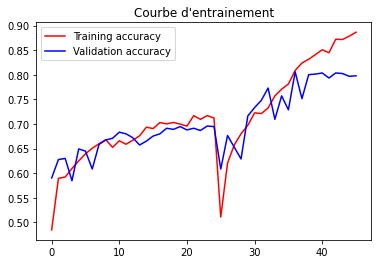


-- Métriques
Accuracy : 0.7874
F1 Score : 0.7920
Quadratic weighted Cohen's kappa = 0.8814

Confusion matrix:
[[218  72   6   3]
 [ 21 165  15   1]
 [  8  35 111   8]
 [  1   6  13 206]]

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       299
           1       0.59      0.82      0.69       202
           2       0.77      0.69      0.72       162
           3       0.94      0.91      0.93       226

    accuracy                           0.79       889
   macro avg       0.80      0.79      0.78       889
weighted avg       0.81      0.79      0.79       889


Accuracy (binary) : 0.8751
F1 Score (binary) : 0.8719
Quadratic weighted Cohen's kappa (binary) : 0.7080

Confusion matrix (binary) :
[[218  81]
 [ 30 560]]

Classification report (binary) :
              precision    recall  f1-score   support

       False       0.88      0.73      0.80       299
        True       0.87      0.95      0.91       59

{'acc': 0.7874015748031497,
 'acc_binary': 0.875140607424072,
 'f1': 0.7919670448265738,
 'f1_binary': 0.871906368342412,
 'k_binary': 0.7080321558440021,
 'kappa': 0.8813708722536508}

In [ ]:
## Exemple d'entrainement et d'évaluation de modèle
## La synthèse des metriques des modèles évalués se trouve dans le notebook "Comparaison des modèles.ipynb"

eval_model = ModelEvaluation(*getVGG16(), image_small=True,classes=4, augmentation = 2, retrain = True)
eval_model.fit(lr = (5e-4, 5e-5))
eval_model.score()